In [1]:
from collections import Counter
import pandas as pd
import os
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import normalize

In [2]:
root = os.getcwd()
train_path = os.path.join(root, 'train.pkl')
test_path = os.path.join(root, 'test_input.pkl')
unlabel_path = os.path.join(root, 'unlabel.pkl')
train_data = pd.read_pickle(train_path)
test_data = pd.read_pickle(test_path)
unlabel_data = pd.read_pickle(unlabel_path)

In [3]:
train_df = pd.DataFrame.from_dict(train_data)
test_df = pd.DataFrame(test_data, columns=['texts'])
unlabel_df = pd.DataFrame(unlabel_data, columns=['texts'])

In [4]:
labels = {i:0 for i in range(3)}
for item in train_data['labels']:
    if item in labels:
        labels[item] += 1
print(labels)

{0: 400, 1: 400, 2: 400}


# length / record

In [36]:
train_df['length'] = train_df['texts'].apply(lambda x: len(x.split()))
train_df


,texts,labels,length
0,32 1042 2524 20 451 120 1895 20 194 1045 3592,0,11
1,3638 4092 20 741 3851 724 676 20 834 63 2718,0,11
2,3749 1030 4147 1144 4138,0,5
3,36 32 3209 3712 1498 2596 4117 4114 1298 36 4113,0,11
4,3502 4125 1676 340,2,4
...,...,...,...
1195,4129 3880 4121 131 1015 3527 395,0,7
1196,36 4114 1298 4119 4116 32 1451 58 3453 4117 41...,2,12
1197,276 3405 2673 4137 32 3437 2216 2920 1222 3252...,0,14
1198,36 81 2654 1137 3352 1001 593 36,2,8


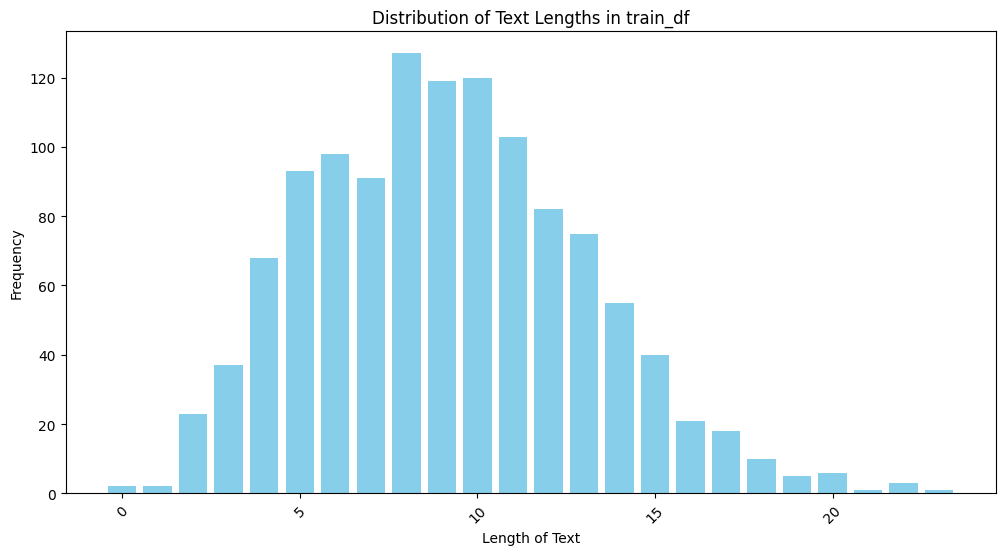

In [37]:
length_counts = train_df['length'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
plt.bar(length_counts.index, length_counts.values, color='skyblue')
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths in train_df')
plt.xticks(rotation=45)
plt.show()

# 1ngram analysis

In [38]:
def count_tokens(text):
    return len(text.split())

def count_token_in_label(token, corpus):
    token_counts = Counter(" ".join(corpus).split())
    return token_counts.get(token, 0)


In [39]:
df_group = train_df.groupby('labels')['texts'].apply(' '.join).reset_index()
df_group['token_length'] = df_group['texts'].apply(lambda x: len(x.split()))
df_group

,labels,texts,token_length
0,0,32 1042 2524 20 451 120 1895 20 194 1045 3592 ...,3983
1,1,3455 3592 4122 4123 36 36 2598 4138 32 983 28...,3411
2,2,3502 4125 1676 340 36 32 3241 36 276 36 3352...,3623


In [40]:
all_texts_concat = ' '.join(df_group['texts'])
total_token_length = len(all_texts_concat.split())

df_total= pd.DataFrame({
    'texts': [all_texts_concat],
    'token_length': [total_token_length]
})

df_total

,texts,token_length
0,32 1042 2524 20 451 120 1895 20 194 1045 3592 ...,11017


In [41]:
label_groups = [0, 1, 2]
df_dict = {}

for label in label_groups:
    subset_corpus = df_group[df_group['labels'] == label]['texts'].values
    cvect = CountVectorizer(ngram_range=(1, 1), token_pattern=r'(?u)\b\w+\b')
    counts = cvect.fit_transform(subset_corpus)
    normalized_counts = normalize(counts, norm='l1', axis=1)
    tfidf = TfidfVectorizer(ngram_range=(1, 1), token_pattern=r'(?u)\b\w+\b', smooth_idf=False)
    tfidf.fit(subset_corpus)
    new_tfs = normalized_counts.multiply(tfidf.idf_)
    
    feature_names = tfidf.get_feature_names_out()
    df_dict[f"Label {label}"] = pd.DataFrame(
        new_tfs.T.todense(), 
        index=feature_names, 
        columns=[f"Document{label}_{i}" for i in range(new_tfs.shape[0])]
    ).mean(axis=1)

full_corpus = df_total['texts'].values
cvect_full = CountVectorizer(ngram_range=(1, 1), token_pattern=r'(?u)\b\w+\b')
counts_full = cvect_full.fit_transform(full_corpus)
normalized_counts_full = normalize(counts_full, norm='l1', axis=1)

tfidf_full = TfidfVectorizer(ngram_range=(1, 1), token_pattern=r'(?u)\b\w+\b', smooth_idf=False)
tfidf_full.fit(full_corpus)
new_tfs_full = normalized_counts_full.multiply(tfidf_full.idf_)

feature_names_full = tfidf_full.get_feature_names_out()
df_dict["Overall Corpus"] = pd.DataFrame(
    new_tfs_full.T.todense(), 
    index=feature_names_full, 
    columns=[f"Document_{i}" for i in range(new_tfs_full.shape[0])]
).mean(axis=1)
result_df = pd.DataFrame(df_dict).reset_index()
result_df.columns = ['Token', 'Frequency_Label_0', 'Frequency_Label_1', 'Frequency_Label_2', 'Frequency_Overall_Corpus']

result_df.fillna(0, inplace=True)
result_df['Count_Label_0'] = result_df['Token'].apply(lambda token: count_token_in_label(token, df_group[df_group['labels'] == 0]['texts']))
result_df['Count_Label_1'] = result_df['Token'].apply(lambda token: count_token_in_label(token, df_group[df_group['labels'] == 1]['texts']))
result_df['Count_Label_2'] = result_df['Token'].apply(lambda token: count_token_in_label(token, df_group[df_group['labels'] == 2]['texts']))

result_df['Count_Overall_Corpus'] = result_df['Token'].apply(lambda token: count_token_in_label(token, df_total['texts']))
total_counts = {
    "Total_Token_Count_Label_0": sum(df_group[df_group['labels'] == 0]['texts'].apply(count_tokens)),
    "Total_Token_Count_Label_1": sum(df_group[df_group['labels'] == 1]['texts'].apply(count_tokens)),
    "Total_Token_Count_Label_2": sum(df_group[df_group['labels'] == 2]['texts'].apply(count_tokens)),
    "Total_Token_Count_Overall_Corpus": sum(df_total['texts'].apply(count_tokens))
}

result_df.head(20)

,Token,Frequency_Label_0,Frequency_Label_1,Frequency_Label_2,Frequency_Overall_Corpus,Count_Label_0,Count_Label_1,Count_Label_2,Count_Overall_Corpus
0,100,0.000251,0.000000,0.000276,0.000182,1,0,1,2
1,1001,0.002511,0.009381,0.008556,0.006626,10,32,31,73
2,1013,0.000251,0.001173,0.000552,0.000635,1,4,2,7
3,1015,0.000251,0.000293,0.000276,0.000272,1,1,1,3
4,1020,0.000251,0.000293,0.000276,0.000272,1,1,1,3
5,1022,0.000000,0.000000,0.000276,0.000091,0,0,1,1
6,1024,0.000251,0.000000,0.000828,0.000363,1,0,3,4
7,1026,0.000251,0.000293,0.000000,0.000182,1,1,0,2
8,1029,0.000000,0.000293,0.000000,0.000091,0,1,0,1
9,1030,0.000502,0.000000,0.000000,0.000182,2,0,0,2


In [42]:
df_Frequency_Label_0_asc = result_df.sort_values('Frequency_Label_0', ascending=True)
df_Frequency_Label_0_asc.to_excel('Frequency_Label_0_asc.xlsx', index=False)
df_Frequency_Label_0_asc

,Token,Frequency_Label_0,Frequency_Label_1,Frequency_Label_2,Frequency_Overall_Corpus,Count_Label_0,Count_Label_1,Count_Label_2,Count_Overall_Corpus
680,2819,0.000000,0.000586,0.000000,0.000182,0,2,0,2
646,2717,0.000000,0.001173,0.000276,0.000454,0,4,1,5
649,2724,0.000000,0.000293,0.000828,0.000363,0,1,3,4
650,2729,0.000000,0.000000,0.000276,0.000091,0,0,1,1
651,2731,0.000000,0.000000,0.000276,0.000091,0,0,1,1
...,...,...,...,...,...,...,...,...,...
398,20,0.043435,0.041337,0.036158,0.040392,173,141,131,445
790,32,0.045694,0.050425,0.051891,0.049197,182,172,188,542
118,1298,0.053979,0.056875,0.049407,0.053372,215,194,179,588
1039,4114,0.055486,0.058634,0.049407,0.054461,221,200,179,600


In [43]:
df_Frequency_Label_0_dcd = result_df.sort_values('Frequency_Label_0', ascending=False)
df_Frequency_Label_0_dcd.to_excel('Frequency_Label_0_dcd.xlsx', index=False)
df_Frequency_Label_0_dcd

,Token,Frequency_Label_0,Frequency_Label_1,Frequency_Label_2,Frequency_Overall_Corpus,Count_Label_0,Count_Label_1,Count_Label_2,Count_Overall_Corpus
913,36,0.082852,0.104661,0.095225,0.093673,330,357,345,1032
1039,4114,0.055486,0.058634,0.049407,0.054461,221,200,179,600
118,1298,0.053979,0.056875,0.049407,0.053372,215,194,179,588
790,32,0.045694,0.050425,0.051891,0.049197,182,172,188,542
398,20,0.043435,0.041337,0.036158,0.040392,173,141,131,445
...,...,...,...,...,...,...,...,...,...
635,268,0.000000,0.000000,0.000276,0.000091,0,0,1,1
636,2680,0.000000,0.000000,0.000276,0.000091,0,0,1,1
641,2693,0.000000,0.000293,0.000000,0.000091,0,1,0,1
642,2700,0.000000,0.000586,0.000000,0.000182,0,2,0,2


In [44]:
df_Frequency_Label_1_asc = result_df.sort_values('Frequency_Label_1', ascending=True)
df_Frequency_Label_1_asc.to_excel('Frequency_Label_1_asc.xlsx', index=False)
df_Frequency_Label_1_asc

,Token,Frequency_Label_0,Frequency_Label_1,Frequency_Label_2,Frequency_Overall_Corpus,Count_Label_0,Count_Label_1,Count_Label_2,Count_Overall_Corpus
0,100,0.000251,0.000000,0.000276,0.000182,1,0,1,2
687,2844,0.000000,0.000000,0.000276,0.000091,0,0,1,1
688,2845,0.000000,0.000000,0.000276,0.000091,0,0,1,1
691,2851,0.000251,0.000000,0.000000,0.000091,1,0,0,1
693,2855,0.000251,0.000000,0.000000,0.000091,1,0,0,1
...,...,...,...,...,...,...,...,...,...
398,20,0.043435,0.041337,0.036158,0.040392,173,141,131,445
790,32,0.045694,0.050425,0.051891,0.049197,182,172,188,542
118,1298,0.053979,0.056875,0.049407,0.053372,215,194,179,588
1039,4114,0.055486,0.058634,0.049407,0.054461,221,200,179,600


In [45]:
df_Frequency_Label_1_dcd = result_df.sort_values('Frequency_Label_1', ascending=False)
df_Frequency_Label_1_dcd.to_excel('Frequency_Label_1_dcd.xlsx', index=False)
df_Frequency_Label_1_dcd

,Token,Frequency_Label_0,Frequency_Label_1,Frequency_Label_2,Frequency_Overall_Corpus,Count_Label_0,Count_Label_1,Count_Label_2,Count_Overall_Corpus
913,36,0.082852,0.104661,0.095225,0.093673,330,357,345,1032
1039,4114,0.055486,0.058634,0.049407,0.054461,221,200,179,600
118,1298,0.053979,0.056875,0.049407,0.053372,215,194,179,588
790,32,0.045694,0.050425,0.051891,0.049197,182,172,188,542
398,20,0.043435,0.041337,0.036158,0.040392,173,141,131,445
...,...,...,...,...,...,...,...,...,...
611,2605,0.000502,0.000000,0.000000,0.000182,2,0,0,2
612,2610,0.000000,0.000000,0.000276,0.000091,0,0,1,1
613,2617,0.000251,0.000000,0.000000,0.000091,1,0,0,1
614,2619,0.000000,0.000000,0.000276,0.000091,0,0,1,1


In [46]:
df_Frequency_Label_2_asc = result_df.sort_values('Frequency_Label_2', ascending=True)
df_Frequency_Label_2_asc.to_excel('Frequency_Label_2_asc.xlsx', index=False)
df_Frequency_Label_2_asc

,Token,Frequency_Label_0,Frequency_Label_1,Frequency_Label_2,Frequency_Overall_Corpus,Count_Label_0,Count_Label_1,Count_Label_2,Count_Overall_Corpus
680,2819,0.000000,0.000586,0.000000,0.000182,0,2,0,2
489,229,0.000000,0.000293,0.000000,0.000091,0,1,0,1
958,3810,0.000753,0.000000,0.000000,0.000272,3,0,0,3
957,3806,0.000251,0.000000,0.000000,0.000091,1,0,0,1
492,2293,0.000753,0.000000,0.000000,0.000272,3,0,0,3
...,...,...,...,...,...,...,...,...,...
398,20,0.043435,0.041337,0.036158,0.040392,173,141,131,445
118,1298,0.053979,0.056875,0.049407,0.053372,215,194,179,588
1039,4114,0.055486,0.058634,0.049407,0.054461,221,200,179,600
790,32,0.045694,0.050425,0.051891,0.049197,182,172,188,542


In [47]:
df_Frequency_Label_2_dcd = result_df.sort_values('Frequency_Label_2', ascending=False)
df_Frequency_Label_2_dcd.to_excel('Frequency_Label_2_dcd.xlsx', index=False)
df_Frequency_Label_2_dcd

,Token,Frequency_Label_0,Frequency_Label_1,Frequency_Label_2,Frequency_Overall_Corpus,Count_Label_0,Count_Label_1,Count_Label_2,Count_Overall_Corpus
913,36,0.082852,0.104661,0.095225,0.093673,330,357,345,1032
790,32,0.045694,0.050425,0.051891,0.049197,182,172,188,542
118,1298,0.053979,0.056875,0.049407,0.053372,215,194,179,588
1039,4114,0.055486,0.058634,0.049407,0.054461,221,200,179,600
398,20,0.043435,0.041337,0.036158,0.040392,173,141,131,445
...,...,...,...,...,...,...,...,...,...
844,3370,0.000251,0.000000,0.000000,0.000091,1,0,0,1
846,3378,0.000502,0.000293,0.000000,0.000272,2,1,0,3
847,3384,0.000251,0.000293,0.000000,0.000182,1,1,0,2
848,3387,0.000502,0.000000,0.000000,0.000182,2,0,0,2


In [48]:
df_Frequency_Label_all_asc = result_df.sort_values('Frequency_Overall_Corpus', ascending=True)
df_Frequency_Label_all_asc.to_excel('df_Frequency_Label_all_asc.xlsx', index=False)
df_Frequency_Label_all_asc

,Token,Frequency_Label_0,Frequency_Label_1,Frequency_Label_2,Frequency_Overall_Corpus,Count_Label_0,Count_Label_1,Count_Label_2,Count_Overall_Corpus
1360,998,0.000000,0.000000,0.000276,0.000091,0,0,1,1
712,2923,0.000000,0.000293,0.000000,0.000091,0,1,0,1
373,1949,0.000000,0.000000,0.000276,0.000091,0,0,1,1
710,2919,0.000251,0.000000,0.000000,0.000091,1,0,0,1
880,3484,0.000000,0.000293,0.000000,0.000091,0,1,0,1
...,...,...,...,...,...,...,...,...,...
398,20,0.043435,0.041337,0.036158,0.040392,173,141,131,445
790,32,0.045694,0.050425,0.051891,0.049197,182,172,188,542
118,1298,0.053979,0.056875,0.049407,0.053372,215,194,179,588
1039,4114,0.055486,0.058634,0.049407,0.054461,221,200,179,600


In [49]:
df_Frequency_Label_all_dcd = result_df.sort_values('Frequency_Overall_Corpus', ascending=False)
df_Frequency_Label_all_dcd.to_excel('df_Frequency_Label_all_dcd.xlsx', index=False)
df_Frequency_Label_all_dcd

,Token,Frequency_Label_0,Frequency_Label_1,Frequency_Label_2,Frequency_Overall_Corpus,Count_Label_0,Count_Label_1,Count_Label_2,Count_Overall_Corpus
913,36,0.082852,0.104661,0.095225,0.093673,330,357,345,1032
1039,4114,0.055486,0.058634,0.049407,0.054461,221,200,179,600
118,1298,0.053979,0.056875,0.049407,0.053372,215,194,179,588
790,32,0.045694,0.050425,0.051891,0.049197,182,172,188,542
398,20,0.043435,0.041337,0.036158,0.040392,173,141,131,445
...,...,...,...,...,...,...,...,...,...
473,2226,0.000000,0.000293,0.000000,0.000091,0,1,0,1
472,2220,0.000251,0.000000,0.000000,0.000091,1,0,0,1
931,3719,0.000000,0.000293,0.000000,0.000091,0,1,0,1
932,373,0.000251,0.000000,0.000000,0.000091,1,0,0,1


# 2ngram analysis

In [50]:

def compute_2gram_counts(corpus, ngram_range=(2, 2)):
    cvect = CountVectorizer(ngram_range=ngram_range, token_pattern=r'(?u)\b\w+\b')
    counts = cvect.fit_transform(corpus)
    feature_names = cvect.get_feature_names_out()
    counts_sum = counts.sum(axis=0).A1  
    return dict(zip(feature_names, counts_sum)), feature_names

df_dict = {}

for label in label_groups:
    subset_corpus = df_group[df_group['labels'] == label]['texts'].values
    
    tfidf = TfidfVectorizer(ngram_range=(2, 2), token_pattern=r'(?u)\b\w+\b', smooth_idf=False)
    tfs = tfidf.fit_transform(subset_corpus)
    feature_names = tfidf.get_feature_names_out()
    
    df_dict[f"Label {label}"] = pd.DataFrame(
        tfs.T.todense(), 
        index=feature_names, 
        columns=[f"Document{label}_{i}" for i in range(tfs.shape[0])]
    ).mean(axis=1)

full_corpus = df_total['texts'].values
tfidf_full = TfidfVectorizer(ngram_range=(2, 2), token_pattern=r'(?u)\b\w+\b', smooth_idf=False)
tfs_full = tfidf_full.fit_transform(full_corpus)

feature_names_full = tfidf_full.get_feature_names_out()

df_dict["Overall Corpus"] = pd.DataFrame(
    tfs_full.T.todense(), 
    index=feature_names_full, 
    columns=[f"Document_{i}" for i in range(tfs_full.shape[0])]
).mean(axis=1)

result_df_2 = pd.DataFrame(df_dict).reset_index()
result_df_2.columns = ['Token', 'Frequency_Label_0', 'Frequency_Label_1', 'Frequency_Label_2', 'Frequency_Overall_Corpus']
result_df_2.fillna(0, inplace=True)

count_data = {
    "Label_0": compute_2gram_counts(df_group[df_group['labels'] == 0]['texts'])[0],
    "Label_1": compute_2gram_counts(df_group[df_group['labels'] == 1]['texts'])[0],
    "Label_2": compute_2gram_counts(df_group[df_group['labels'] == 2]['texts'])[0],
    "Overall_Corpus": compute_2gram_counts(df_total['texts'])[0]
}

result_df_2['Count_Label_0'] = result_df_2['Token'].map(count_data["Label_0"]).fillna(0).astype(int)
result_df_2['Count_Label_1'] = result_df_2['Token'].map(count_data["Label_1"]).fillna(0).astype(int)
result_df_2['Count_Label_2'] = result_df_2['Token'].map(count_data["Label_2"]).fillna(0).astype(int)
result_df_2['Count_Overall_Corpus'] = result_df_2['Token'].map(count_data["Overall_Corpus"]).fillna(0).astype(int)

result_df_2.head(20)


,Token,Frequency_Label_0,Frequency_Label_1,Frequency_Label_2,Frequency_Overall_Corpus,Count_Label_0,Count_Label_1,Count_Label_2,Count_Overall_Corpus
0,100 1032,0.000000,0.000000,0.004577,0.001448,0,0,1,1
1,100 756,0.003891,0.000000,0.000000,0.001448,1,0,0,1
2,1001 1040,0.000000,0.000000,0.004577,0.001448,0,0,1,1
3,1001 1045,0.003891,0.000000,0.000000,0.001448,1,0,0,1
4,1001 112,0.000000,0.000000,0.004577,0.001448,0,0,1,1
5,1001 1437,0.000000,0.000000,0.004577,0.001448,0,0,1,1
6,1001 146,0.000000,0.000000,0.004577,0.001448,0,0,1,1
7,1001 1675,0.000000,0.000000,0.004577,0.001448,0,0,1,1
8,1001 17,0.000000,0.004234,0.000000,0.001448,0,1,0,1
9,1001 20,0.003891,0.008468,0.013731,0.008688,1,2,3,6


In [51]:
df_Frequency_Label_0_asc_2ng = result_df_2.sort_values('Frequency_Label_0', ascending=True)
df_Frequency_Label_0_asc_2ng.to_excel('Frequency_Label_0_2ng_asc.xlsx', index=False)
df_Frequency_Label_0_asc_2ng

,Token,Frequency_Label_0,Frequency_Label_1,Frequency_Label_2,Frequency_Overall_Corpus,Count_Label_0,Count_Label_1,Count_Label_2,Count_Overall_Corpus
0,100 1032,0.000000,0.000000,0.004577,0.001448,0,0,1,1
3435,36 3774,0.000000,0.000000,0.004577,0.001448,0,0,1,1
3438,36 3802,0.000000,0.000000,0.004577,0.001448,0,0,1,1
3440,36 3863,0.000000,0.004234,0.000000,0.001448,0,1,0,1
3443,36 3934,0.000000,0.004234,0.000000,0.001448,0,1,0,1
...,...,...,...,...,...,...,...,...,...
3474,36 4129,0.128406,0.190531,0.146469,0.159285,33,45,32,110
4393,4117 4114,0.147861,0.190531,0.119006,0.157836,38,45,26,109
3426,36 36,0.171208,0.198999,0.201395,0.195486,44,47,44,135
519,1298 4114,0.217900,0.173595,0.146469,0.186797,56,41,32,129


In [52]:
df_Frequency_Label_0_dcd_2ng = result_df_2.sort_values('Frequency_Label_0', ascending=False)
df_Frequency_Label_0_dcd_2ng.to_excel('Frequency_Label_0_2ng_dcd.xlsx', index=False)
df_Frequency_Label_0_dcd_2ng

,Token,Frequency_Label_0,Frequency_Label_1,Frequency_Label_2,Frequency_Overall_Corpus,Count_Label_0,Count_Label_1,Count_Label_2,Count_Overall_Corpus
4302,4114 1298,0.836582,0.821400,0.819310,0.851448,215,194,179,588
519,1298 4114,0.217900,0.173595,0.146469,0.186797,56,41,32,129
3426,36 36,0.171208,0.198999,0.201395,0.195486,44,47,44,135
4393,4117 4114,0.147861,0.190531,0.119006,0.157836,38,45,26,109
3474,36 4129,0.128406,0.190531,0.146469,0.159285,33,45,32,110
...,...,...,...,...,...,...,...,...,...
2579,3124 695,0.000000,0.004234,0.000000,0.001448,0,1,0,1
2580,3128 2083,0.000000,0.004234,0.000000,0.001448,0,1,0,1
2581,3128 3749,0.000000,0.000000,0.004577,0.001448,0,0,1,1
2582,3128 4119,0.000000,0.004234,0.000000,0.001448,0,1,0,1


In [53]:
df_Frequency_Label_1_asc_2ng = result_df_2.sort_values('Frequency_Label_1', ascending=True)
df_Frequency_Label_1_asc_2ng.to_excel('Frequency_Label_1_2ng_asc.xlsx', index=False)
df_Frequency_Label_1_asc_2ng

,Token,Frequency_Label_0,Frequency_Label_1,Frequency_Label_2,Frequency_Overall_Corpus,Count_Label_0,Count_Label_1,Count_Label_2,Count_Overall_Corpus
0,100 1032,0.000000,0.000000,0.004577,0.001448,0,0,1,1
3669,3749 1890,0.003891,0.000000,0.000000,0.001448,1,0,0,1
3668,3749 170,0.003891,0.000000,0.000000,0.001448,1,0,0,1
3667,3749 17,0.000000,0.000000,0.004577,0.001448,0,0,1,1
3666,3749 1585,0.000000,0.000000,0.004577,0.001448,0,0,1,1
...,...,...,...,...,...,...,...,...,...
519,1298 4114,0.217900,0.173595,0.146469,0.186797,56,41,32,129
3474,36 4129,0.128406,0.190531,0.146469,0.159285,33,45,32,110
4393,4117 4114,0.147861,0.190531,0.119006,0.157836,38,45,26,109
3426,36 36,0.171208,0.198999,0.201395,0.195486,44,47,44,135


In [54]:
df_Frequency_Label_1_dcd_2ng = result_df_2.sort_values('Frequency_Label_1', ascending=False)
df_Frequency_Label_1_dcd_2ng.to_excel('Frequency_Label_1_2ng_dcd.xlsx', index=False)
df_Frequency_Label_1_dcd_2ng

,Token,Frequency_Label_0,Frequency_Label_1,Frequency_Label_2,Frequency_Overall_Corpus,Count_Label_0,Count_Label_1,Count_Label_2,Count_Overall_Corpus
4302,4114 1298,0.836582,0.821400,0.819310,0.851448,215,194,179,588
3426,36 36,0.171208,0.198999,0.201395,0.195486,44,47,44,135
3474,36 4129,0.128406,0.190531,0.146469,0.159285,33,45,32,110
4393,4117 4114,0.147861,0.190531,0.119006,0.157836,38,45,26,109
519,1298 4114,0.217900,0.173595,0.146469,0.186797,56,41,32,129
...,...,...,...,...,...,...,...,...,...
2368,2842 421,0.003891,0.000000,0.000000,0.001448,1,0,0,1
2367,2839 4119,0.000000,0.000000,0.009154,0.002896,0,0,2,2
2366,2839 20,0.000000,0.000000,0.004577,0.001448,0,0,1,1
2365,2837 17,0.000000,0.000000,0.004577,0.001448,0,0,1,1


In [55]:
df_Frequency_Label_2_asc_2ng = result_df_2.sort_values('Frequency_Label_2', ascending=True)
df_Frequency_Label_2_asc_2ng.to_excel('Frequency_Label_2_2ng_asc.xlsx', index=False)
df_Frequency_Label_2_asc_2ng

,Token,Frequency_Label_0,Frequency_Label_1,Frequency_Label_2,Frequency_Overall_Corpus,Count_Label_0,Count_Label_1,Count_Label_2,Count_Overall_Corpus
5241,47 20,0.003891,0.004234,0.000000,0.002896,1,1,0,2
2740,32 325,0.000000,0.004234,0.000000,0.001448,0,1,0,1
2741,32 3274,0.003891,0.000000,0.000000,0.001448,1,0,0,1
5022,4165 184,0.000000,0.004234,0.000000,0.001448,0,1,0,1
5021,4165 1653,0.000000,0.004234,0.000000,0.001448,0,1,0,1
...,...,...,...,...,...,...,...,...,...
4487,4122 4123,0.023346,0.071978,0.137315,0.076746,6,17,30,53
519,1298 4114,0.217900,0.173595,0.146469,0.186797,56,41,32,129
3474,36 4129,0.128406,0.190531,0.146469,0.159285,33,45,32,110
3426,36 36,0.171208,0.198999,0.201395,0.195486,44,47,44,135


In [56]:
df_Frequency_Label_2_dcd_2ng = result_df_2.sort_values('Frequency_Label_2', ascending=False)
df_Frequency_Label_2_dcd_2ng.to_excel('Frequency_Label_2_2ng_dcd.xlsx', index=False)
df_Frequency_Label_2_dcd_2ng

,Token,Frequency_Label_0,Frequency_Label_1,Frequency_Label_2,Frequency_Overall_Corpus,Count_Label_0,Count_Label_1,Count_Label_2,Count_Overall_Corpus
4302,4114 1298,0.836582,0.821400,0.819310,0.851448,215,194,179,588
3426,36 36,0.171208,0.198999,0.201395,0.195486,44,47,44,135
519,1298 4114,0.217900,0.173595,0.146469,0.186797,56,41,32,129
3474,36 4129,0.128406,0.190531,0.146469,0.159285,33,45,32,110
4487,4122 4123,0.023346,0.071978,0.137315,0.076746,6,17,30,53
...,...,...,...,...,...,...,...,...,...
3296,3592 456,0.000000,0.004234,0.000000,0.001448,0,1,0,1
3297,3592 47,0.007782,0.000000,0.000000,0.002896,2,0,0,2
1125,1726 2718,0.000000,0.004234,0.000000,0.001448,0,1,0,1
1124,1726 20,0.000000,0.004234,0.000000,0.001448,0,1,0,1


In [57]:
df_Frequency_Label_all_asc_2ng = result_df_2.sort_values('Frequency_Overall_Corpus', ascending=True)
df_Frequency_Label_all_asc_2ng.to_excel('df_Frequency_Label_all_2ng_asc.xlsx', index=False)
df_Frequency_Label_all_asc_2ng

,Token,Frequency_Label_0,Frequency_Label_1,Frequency_Label_2,Frequency_Overall_Corpus,Count_Label_0,Count_Label_1,Count_Label_2,Count_Overall_Corpus
0,100 1032,0.000000,0.000000,0.004577,0.001448,0,0,1,1
3894,3945 36,0.000000,0.004234,0.000000,0.001448,0,1,0,1
3893,3941 724,0.000000,0.004234,0.000000,0.001448,0,1,0,1
3892,3941 36,0.000000,0.004234,0.000000,0.001448,0,1,0,1
3891,3934 4124,0.000000,0.004234,0.000000,0.001448,0,1,0,1
...,...,...,...,...,...,...,...,...,...
4393,4117 4114,0.147861,0.190531,0.119006,0.157836,38,45,26,109
3474,36 4129,0.128406,0.190531,0.146469,0.159285,33,45,32,110
519,1298 4114,0.217900,0.173595,0.146469,0.186797,56,41,32,129
3426,36 36,0.171208,0.198999,0.201395,0.195486,44,47,44,135


In [58]:
df_Frequency_Label_all_dcd_2ng = result_df_2.sort_values('Frequency_Overall_Corpus', ascending=False)
df_Frequency_Label_all_dcd_2ng.to_excel('df_Frequency_Label_all_2ng_dcd.xlsx', index=False)
df_Frequency_Label_all_dcd_2ng

,Token,Frequency_Label_0,Frequency_Label_1,Frequency_Label_2,Frequency_Overall_Corpus,Count_Label_0,Count_Label_1,Count_Label_2,Count_Overall_Corpus
4302,4114 1298,0.836582,0.821400,0.819310,0.851448,215,194,179,588
3426,36 36,0.171208,0.198999,0.201395,0.195486,44,47,44,135
519,1298 4114,0.217900,0.173595,0.146469,0.186797,56,41,32,129
3474,36 4129,0.128406,0.190531,0.146469,0.159285,33,45,32,110
4393,4117 4114,0.147861,0.190531,0.119006,0.157836,38,45,26,109
...,...,...,...,...,...,...,...,...,...
2171,2670 1042,0.003891,0.000000,0.000000,0.001448,1,0,0,1
2170,2667 395,0.000000,0.000000,0.004577,0.001448,0,0,1,1
2168,2667 20,0.000000,0.000000,0.004577,0.001448,0,0,1,1
2167,2666 2928,0.000000,0.004234,0.000000,0.001448,0,1,0,1


# 3ngram analysis

In [59]:
def compute_3gram_counts(corpus, ngram_range=(3, 3)):
    cvect = CountVectorizer(ngram_range=ngram_range, token_pattern=r'(?u)\b\w+\b')
    counts = cvect.fit_transform(corpus)
    feature_names = cvect.get_feature_names_out()
    counts_sum = counts.sum(axis=0).A1  
    return dict(zip(feature_names, counts_sum)), feature_names

df_dict = {}

for label in label_groups:
    subset_corpus = df_group[df_group['labels'] == label]['texts'].values
    tfidf = TfidfVectorizer(ngram_range=(3, 3), token_pattern=r'(?u)\b\w+\b', smooth_idf=False)
    tfs = tfidf.fit_transform(subset_corpus)
    
    feature_names = tfidf.get_feature_names_out()
    
    df_dict[f"Label {label}"] = pd.DataFrame(
        tfs.T.todense(), 
        index=feature_names, 
        columns=[f"Document{label}_{i}" for i in range(tfs.shape[0])]
    ).mean(axis=1)

full_corpus = df_total['texts'].values
tfidf_full = TfidfVectorizer(ngram_range=(3, 3), token_pattern=r'(?u)\b\w+\b', smooth_idf=False)
tfs_full = tfidf_full.fit_transform(full_corpus)

feature_names_full = tfidf_full.get_feature_names_out()

df_dict["Overall Corpus"] = pd.DataFrame(
    tfs_full.T.todense(), 
    index=feature_names_full, 
    columns=[f"Document_{i}" for i in range(tfs_full.shape[0])]
).mean(axis=1)

result_df_3 = pd.DataFrame(df_dict).reset_index()
result_df_3.columns = ['Token', 'Frequency_Label_0', 'Frequency_Label_1', 'Frequency_Label_2', 'Frequency_Overall_Corpus']
result_df_3.fillna(0, inplace=True)

count_data = {
    "Label_0": compute_3gram_counts(df_group[df_group['labels'] == 0]['texts'])[0],
    "Label_1": compute_3gram_counts(df_group[df_group['labels'] == 1]['texts'])[0],
    "Label_2": compute_3gram_counts(df_group[df_group['labels'] == 2]['texts'])[0],
    "Overall_Corpus": compute_3gram_counts(df_total['texts'])[0]
}

result_df_3['Count_Label_0'] = result_df_3['Token'].map(count_data["Label_0"]).fillna(0).astype(int)
result_df_3['Count_Label_1'] = result_df_3['Token'].map(count_data["Label_1"]).fillna(0).astype(int)
result_df_3['Count_Label_2'] = result_df_3['Token'].map(count_data["Label_2"]).fillna(0).astype(int)
result_df_3['Count_Overall_Corpus'] = result_df_3['Token'].map(count_data["Overall_Corpus"]).fillna(0).astype(int)

result_df_3.head(20)


,Token,Frequency_Label_0,Frequency_Label_1,Frequency_Label_2,Frequency_Overall_Corpus,Count_Label_0,Count_Label_1,Count_Label_2,Count_Overall_Corpus
0,100 1032 4170,0.000000,0.000000,0.010687,0.00356,0,0,1,1
1,100 756 68,0.008191,0.000000,0.000000,0.00356,1,0,0,1
2,1001 1040 1658,0.000000,0.000000,0.010687,0.00356,0,0,1,1
3,1001 1045 4133,0.008191,0.000000,0.000000,0.00356,1,0,0,1
4,1001 112 2667,0.000000,0.000000,0.010687,0.00356,0,0,1,1
5,1001 1437 341,0.000000,0.000000,0.010687,0.00356,0,0,1,1
6,1001 146 1902,0.000000,0.000000,0.010687,0.00356,0,0,1,1
7,1001 1675 711,0.000000,0.000000,0.010687,0.00356,0,0,1,1
8,1001 17 2853,0.000000,0.009304,0.000000,0.00356,0,1,0,1
9,1001 20 1096,0.000000,0.009304,0.000000,0.00356,0,1,0,1


In [60]:
df_Frequency_Label_0_asc_3ng = result_df_3.sort_values('Frequency_Label_0', ascending=True)
df_Frequency_Label_0_asc_3ng.to_excel('Frequency_Label_0_3ng_asc.xlsx', index=False)
df_Frequency_Label_0_asc_3ng

,Token,Frequency_Label_0,Frequency_Label_1,Frequency_Label_2,Frequency_Overall_Corpus,Count_Label_0,Count_Label_1,Count_Label_2,Count_Overall_Corpus
0,100 1032 4170,0.000000,0.000000,0.010687,0.003560,0,0,1,1
5021,36 945 1838,0.000000,0.009304,0.000000,0.003560,0,1,0,1
5019,36 94 855,0.000000,0.000000,0.010687,0.003560,0,0,1,1
5017,36 852 36,0.000000,0.009304,0.000000,0.003560,0,1,0,1
5016,36 83 158,0.000000,0.009304,0.000000,0.003560,0,1,0,1
...,...,...,...,...,...,...,...,...,...
6171,4114 1298 32,0.122872,0.167465,0.170998,0.174446,15,18,16,49
6188,4114 1298 36,0.180213,0.288413,0.256498,0.274129,22,31,24,77
6422,4117 4114 1298,0.311277,0.400056,0.277872,0.380933,38,43,26,107
6212,4114 1298 4114,0.458724,0.381449,0.341997,0.459255,56,41,32,129


In [61]:
df_Frequency_Label_0_dcd_3ng = result_df_3.sort_values('Frequency_Label_0', ascending=False)
df_Frequency_Label_0_dcd_3ng.to_excel('Frequency_Label_0_3ng_dcd.xlsx', index=False)
df_Frequency_Label_0_dcd_3ng

,Token,Frequency_Label_0,Frequency_Label_1,Frequency_Label_2,Frequency_Overall_Corpus,Count_Label_0,Count_Label_1,Count_Label_2,Count_Overall_Corpus
742,1298 4114 1298,0.458724,0.381449,0.341997,0.459255,56,41,32,129
6212,4114 1298 4114,0.458724,0.381449,0.341997,0.459255,56,41,32,129
6422,4117 4114 1298,0.311277,0.400056,0.277872,0.380933,38,43,26,107
6188,4114 1298 36,0.180213,0.288413,0.256498,0.274129,22,31,24,77
6983,4133 4114 1298,0.122872,0.130251,0.106874,0.138845,15,14,10,39
...,...,...,...,...,...,...,...,...,...
3582,32 3592 48,0.000000,0.009304,0.000000,0.003560,0,1,0,1
3580,32 3592 4143,0.000000,0.009304,0.000000,0.003560,0,1,0,1
3578,32 3592 4114,0.000000,0.009304,0.000000,0.003560,0,1,0,1
3576,32 3592 3749,0.000000,0.000000,0.010687,0.003560,0,0,1,1


In [62]:
df_Frequency_Label_1_asc_3ng = result_df_3.sort_values('Frequency_Label_1', ascending=True)
df_Frequency_Label_1_asc_3ng.to_excel('Frequency_Label_1_3ng_asc.xlsx', index=False)
df_Frequency_Label_1_asc_3ng

,Token,Frequency_Label_0,Frequency_Label_1,Frequency_Label_2,Frequency_Overall_Corpus,Count_Label_0,Count_Label_1,Count_Label_2,Count_Overall_Corpus
0,100 1032 4170,0.000000,0.000000,0.010687,0.003560,0,0,1,1
5314,3749 4139 1050,0.000000,0.000000,0.010687,0.003560,0,0,1,1
5311,3749 4130 20,0.000000,0.000000,0.010687,0.003560,0,0,1,1
5310,3749 4129 593,0.008191,0.000000,0.000000,0.003560,1,0,0,1
5308,3749 4129 3743,0.008191,0.000000,0.000000,0.003560,1,0,0,1
...,...,...,...,...,...,...,...,...,...
6171,4114 1298 32,0.122872,0.167465,0.170998,0.174446,15,18,16,49
6188,4114 1298 36,0.180213,0.288413,0.256498,0.274129,22,31,24,77
742,1298 4114 1298,0.458724,0.381449,0.341997,0.459255,56,41,32,129
6212,4114 1298 4114,0.458724,0.381449,0.341997,0.459255,56,41,32,129


In [63]:
df_Frequency_Label_1_dcd_3ng = result_df_3.sort_values('Frequency_Label_1', ascending=False)
df_Frequency_Label_1_dcd_3ng.to_excel('Frequency_Label_1_3ng_dcd.xlsx', index=False)
df_Frequency_Label_1_dcd_3ng

,Token,Frequency_Label_0,Frequency_Label_1,Frequency_Label_2,Frequency_Overall_Corpus,Count_Label_0,Count_Label_1,Count_Label_2,Count_Overall_Corpus
6422,4117 4114 1298,0.311277,0.400056,0.277872,0.380933,38,43,26,107
6212,4114 1298 4114,0.458724,0.381449,0.341997,0.459255,56,41,32,129
742,1298 4114 1298,0.458724,0.381449,0.341997,0.459255,56,41,32,129
6188,4114 1298 36,0.180213,0.288413,0.256498,0.274129,22,31,24,77
6171,4114 1298 32,0.122872,0.167465,0.170998,0.174446,15,18,16,49
...,...,...,...,...,...,...,...,...,...
3376,32 1128 1934,0.008191,0.000000,0.000000,0.003560,1,0,0,1
3375,32 1118 1939,0.008191,0.000000,0.000000,0.003560,1,0,0,1
3372,32 1088 32,0.000000,0.000000,0.010687,0.003560,0,0,1,1
3370,32 1061 2112,0.000000,0.000000,0.010687,0.003560,0,0,1,1


In [64]:
df_Frequency_Label_2_asc_3ng = result_df_3.sort_values('Frequency_Label_2', ascending=True)
df_Frequency_Label_2_asc_3ng.to_excel('Frequency_Label_2_3ng_asc.xlsx', index=False)
df_Frequency_Label_2_asc_3ng

,Token,Frequency_Label_0,Frequency_Label_1,Frequency_Label_2,Frequency_Overall_Corpus,Count_Label_0,Count_Label_1,Count_Label_2,Count_Overall_Corpus
7558,421 48 4158,0.008191,0.000000,0.000000,0.003560,1,0,0,1
7203,4145 36 1976,0.000000,0.009304,0.000000,0.003560,0,1,0,1
4102,3437 36 2216,0.008191,0.000000,0.000000,0.003560,1,0,0,1
4101,3437 2216 2920,0.057340,0.000000,0.000000,0.024921,7,0,0,7
7204,4145 36 2216,0.008191,0.000000,0.000000,0.003560,1,0,0,1
...,...,...,...,...,...,...,...,...,...
6171,4114 1298 32,0.122872,0.167465,0.170998,0.174446,15,18,16,49
6188,4114 1298 36,0.180213,0.288413,0.256498,0.274129,22,31,24,77
6422,4117 4114 1298,0.311277,0.400056,0.277872,0.380933,38,43,26,107
6212,4114 1298 4114,0.458724,0.381449,0.341997,0.459255,56,41,32,129


In [65]:
df_Frequency_Label_2_dcd_3ng = result_df_3.sort_values('Frequency_Label_2', ascending=False)
df_Frequency_Label_2_dcd_3ng.to_excel('Frequency_Label_2_3ng_dcd.xlsx', index=False)
df_Frequency_Label_2_dcd_3ng

,Token,Frequency_Label_0,Frequency_Label_1,Frequency_Label_2,Frequency_Overall_Corpus,Count_Label_0,Count_Label_1,Count_Label_2,Count_Overall_Corpus
6212,4114 1298 4114,0.458724,0.381449,0.341997,0.459255,56,41,32,129
742,1298 4114 1298,0.458724,0.381449,0.341997,0.459255,56,41,32,129
6422,4117 4114 1298,0.311277,0.400056,0.277872,0.380933,38,43,26,107
6188,4114 1298 36,0.180213,0.288413,0.256498,0.274129,22,31,24,77
6171,4114 1298 32,0.122872,0.167465,0.170998,0.174446,15,18,16,49
...,...,...,...,...,...,...,...,...,...
1476,1730 127 1199,0.008191,0.000000,0.000000,0.003560,1,0,0,1
4562,36 32 971,0.008191,0.000000,0.000000,0.003560,1,0,0,1
1477,1730 1671 3352,0.000000,0.009304,0.000000,0.003560,0,1,0,1
4559,36 32 80,0.008191,0.000000,0.000000,0.003560,1,0,0,1


In [66]:
df_Frequency_Label_all_asc_3ng = result_df_3.sort_values('Frequency_Overall_Corpus', ascending=True)
df_Frequency_Label_all_asc_3ng.to_excel('df_Frequency_Label_all_3ng_asc.xlsx', index=False)
df_Frequency_Label_all_asc_3ng

,Token,Frequency_Label_0,Frequency_Label_1,Frequency_Label_2,Frequency_Overall_Corpus,Count_Label_0,Count_Label_1,Count_Label_2,Count_Overall_Corpus
0,100 1032 4170,0.000000,0.000000,0.010687,0.003560,0,0,1,1
5684,3977 327 3749,0.000000,0.009304,0.000000,0.003560,0,1,0,1
5683,3977 32 36,0.000000,0.000000,0.010687,0.003560,0,0,1,1
5682,3977 32 1391,0.000000,0.000000,0.010687,0.003560,0,0,1,1
5681,3977 32 1332,0.000000,0.000000,0.010687,0.003560,0,0,1,1
...,...,...,...,...,...,...,...,...,...
6171,4114 1298 32,0.122872,0.167465,0.170998,0.174446,15,18,16,49
6188,4114 1298 36,0.180213,0.288413,0.256498,0.274129,22,31,24,77
6422,4117 4114 1298,0.311277,0.400056,0.277872,0.380933,38,43,26,107
742,1298 4114 1298,0.458724,0.381449,0.341997,0.459255,56,41,32,129


In [67]:
df_Frequency_Label_all_dcd_3ng = result_df_3.sort_values('Frequency_Overall_Corpus', ascending=False)
df_Frequency_Label_all_dcd_3ng.to_excel('df_Frequency_Label_all_3ng_dcd.xlsx', index=False)
df_Frequency_Label_all_dcd_3ng

,Token,Frequency_Label_0,Frequency_Label_1,Frequency_Label_2,Frequency_Overall_Corpus,Count_Label_0,Count_Label_1,Count_Label_2,Count_Overall_Corpus
6212,4114 1298 4114,0.458724,0.381449,0.341997,0.459255,56,41,32,129
742,1298 4114 1298,0.458724,0.381449,0.341997,0.459255,56,41,32,129
6422,4117 4114 1298,0.311277,0.400056,0.277872,0.380933,38,43,26,107
6188,4114 1298 36,0.180213,0.288413,0.256498,0.274129,22,31,24,77
6171,4114 1298 32,0.122872,0.167465,0.170998,0.174446,15,18,16,49
...,...,...,...,...,...,...,...,...,...
2987,2718 872 4113,0.000000,0.009304,0.000000,0.003560,0,1,0,1
2986,2718 824 4134,0.008191,0.000000,0.000000,0.003560,1,0,0,1
2985,2718 791 32,0.000000,0.000000,0.010687,0.003560,0,0,1,1
2984,2718 780 355,0.000000,0.009304,0.000000,0.003560,0,1,0,1


# Chunk unlabeled dataset

In [5]:
def chunk_text(text, chunk_size=10):
    words = text.split() 
    return [' '.join(words[i:i + chunk_size]) for i in range(0, len(words), chunk_size)]

chunked_texts = []
for text in unlabel_df['texts']:
    chunked_texts.extend(chunk_text(text, chunk_size=10))

chunked_texts_df = pd.DataFrame(chunked_texts, columns=['texts'])
chunked_texts_df.to_csv("chunked_unlabeled_texts.csv", index=False)